In [43]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yahooquery as yq
import random

%matplotlib inline
import matplotlib.pyplot as plt
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

from ConformalMethods import AdaptiveCP, ACP_plots, ACP_data

We will create a series of variances.
We will then use this series of variances to generate normals.
We will then use these normals to fit chebyshevs in.
We will create a method to claculate the coverage of chebyshevs.

In [2]:
length = 2500
alpha = 0.1

In [3]:
variance_array = pd.Series(np.random.uniform(0.5, 3, length))

In [4]:
corresponding_normal = pd.Series(np.random.normal(0, variance_array, length))

In [5]:
def chebyshev(var, alpha):
    # alpha is the coverage that we want so var/k^2 = alpha
    k = np.sqrt(var/alpha)
    
    return (-k, k)

# vectorise chebyshev
chebyshev_v = np.vectorize(chebyshev)


In [6]:
chebyshev_bounds = pd.Series([chebyshev(var, alpha) for var in variance_array])

In [7]:
print(chebyshev_bounds[0:10])

0      (-2.969627874831517, 2.969627874831517)
1      (-2.889890070317316, 2.889890070317316)
2    (-3.6420533207656316, 3.6420533207656316)
3      (-5.350383999182983, 5.350383999182983)
4      (-4.557121718325786, 4.557121718325786)
5      (-3.757716852973472, 3.757716852973472)
6    (-3.2302674700054577, 3.2302674700054577)
7      (-4.490043732718717, 4.490043732718717)
8      (-3.084033807543104, 3.084033807543104)
9      (-4.765841652032896, 4.765841652032896)
dtype: object


In [8]:
# Now we will write a coverage function.
def coverage(chebyshev_bounds, normal):
    return (chebyshev_bounds[0] < normal) & (chebyshev_bounds[1] > normal)
coverage_v = np.vectorize(coverage)

coverage_array = coverage_v(chebyshev_bounds, corresponding_normal)

In [9]:
print(pd.Series(coverage_array).mean())
# As expected chebyshev is very conservative. We will now try to use the adaptive conformal prediction method to get a better coverage.

0.9776


## The adaptive method.
We will use an exponetial reweighting. We will use the variance covariate to calculate chebyshev. Then we need to weight them by the pinball loss. This method is very similar to DtACI. So adapting that wont be silly.

In [10]:
class Cheb(AdaptiveCP):
    def __init__(self, alpha):
            self.alpha = alpha
            self.coverage_target = alpha
            self.interval_size = 100

    def fraction_chebyshev_set_and_k(self, var, alpha, fraction):
        k = np.sqrt(var/alpha)
        adapted_k = k * (1+fraction)
        return k, (-adapted_k, adapted_k)

    def FrCheb(self, variance_normal: tuple, min_max_many: tuple = (-0.5, 0.5, 10), title: str = None, ) -> dict:
            ''' Implementation of the Dynamic Adaptive Conformal Prediction method, also commonly know as FACI'''
            
            variance_array, normal_array = variance_normal # Change to variances and normal data
            
            # These are the heads.
            fraction_candidates = np.linspace(min_max_many[0], min_max_many[1], min_max_many[2])
        
            final_weights = np.array([1 for _ in fraction_candidates])
            
            chosen_fraction_index = []
            err_t_list = []
            conformal_sets_list = []
            chosen_fraction_list = []
            alpha_error_list = []
            optimal_fraction_list = []
            
            sigma = 1/(2*self.interval_size)
            nu = np.sqrt((3/self.interval_size) * (np.log(len(fraction_candidates)*self.interval_size) + 2)/((1-self.coverage_target)**2 * self.coverage_target**2))

            #set_loss = self.set_loss_vectorize()

            for i in range(len(normal_array)):
                # Calcualting the probability of each gamma from the weights from step t-1.
                #Wt = gamma_weights.sum()
                #gamma_probabilites = gamma_weights/Wt
                
                # Choosing a alpha from the probabilites from the gamma candidates.
                chosen_fraction = random.choices(fraction_candidates, weights=final_weights, k=1)[0] # candidate alpha is redundant, just replace with head values.
                chosen_fraction_list.append(chosen_fraction)
                candiate_fraction_index = np.where(fraction_candidates == chosen_fraction)[0][0]
                chosen_fraction_index.append(candiate_fraction_index)

                # This is the generation of the intervals. It does not need to be vectorised.
                cheb_k, conformal_set = self.fraction_chebyshev_set_and_k(variance_array[i], self.alpha, chosen_fraction)
                conformal_sets_list.append(conformal_set)
                
                err_true = AdaptiveCP.err_t(normal_array[i], conformal_set) # this is still good
                err_t_list.append(err_true)

                # TIME FRONTIER -------

                # could we just do absolute value from the true fraction? <- Would be very easy to implement.
                optimal_fraction = (abs(normal_array[i])/cheb_k) - 1
                optimal_fraction_list.append(optimal_fraction)
                # calculate the losses as the mean squared error.
                
                set_loss = np.array([self.set_loss(optimal_fraction, fraction) for fraction in fraction_candidates])
                # Updating the weights.
                new_weights = final_weights * np.exp(-nu * set_loss) # replace l vec.
                
                sumW, lenW = sum(new_weights), len(new_weights)
                final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)
                final_weights /= sum(final_weights)

                

            # Calculating different averages
            realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(self.interval_size).mean().mean()
            average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])
            
            return {
                'model': title if title is not None else 'DtACI',
                'coverage_target': self.coverage_target,
                'fraction_candidates': fraction_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'chosen_fraction_list': chosen_fraction_list,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'alpha_error_list': alpha_error_list,
                'optimal_fraction_list': optimal_fraction_list,
                'interval_size': self.interval_size

            }


In [11]:
class Cheb2(AdaptiveCP):
    def __init__(self, alpha):
        self.alpha = alpha
        self.coverage_target = alpha
        self.interval_size = 100

    def fraction_chebyshev_set_and_k(self, var, alpha, fraction):
        k = np.sqrt(var/alpha)
        return k, (-k*fraction, k*fraction)
    
    def set_loss(self, optimal_set, given_set):
        # If the optimal set is somehow 0, then we will return the given set.
        if optimal_set == 0:
            return 0
        else:
            val = (optimal_set - given_set)
         
        if val < 0:
            return (self.coverage_target) * (-1* val)
        else:
            return (1 - self.coverage_target) * val

    def FrCheb(self, variance_normal: tuple, min_max_many: tuple = (-0.5, 0.5, 10), title: str = None, verbose=False ) -> dict:
            ''' Implementation of the Dynamic Adaptive Conformal Prediction method, also commonly know as FACI'''
            
            variance_array, normal_array = variance_normal # Change to variances and normal data
            
            # These are the heads.
            fraction_candidates = np.linspace(min_max_many[0], min_max_many[1], min_max_many[2])
        
            final_weights = np.array([1 for _ in fraction_candidates])
            
            chosen_fraction_index = []
            err_t_list = []
            conformal_sets_list = []
            chosen_fraction_list = []
            alpha_error_list = []
            optimal_fraction_list = []
            
            sigma = 1/(2*self.interval_size)
            nu = np.sqrt((3/self.interval_size) * (np.log(len(fraction_candidates)*self.interval_size) + 2)/((1-self.coverage_target)**2 * self.coverage_target**2))

            #set_loss = self.set_loss_vectorize()

            for i in range(len(normal_array)):
                if verbose:
                    print(f'{i=}')
                    
                chosen_fraction = random.choices(fraction_candidates, weights=final_weights, k=1)[0] # candidate alpha is redundant, just replace with head values.
                
                chosen_fraction_list.append(chosen_fraction)
                candiate_fraction_index = np.where(fraction_candidates == chosen_fraction)[0][0]
                chosen_fraction_index.append(candiate_fraction_index)

                # This is the generation of the intervals. It does not need to be vectorised.
                cheb_k, conformal_set = self.fraction_chebyshev_set_and_k(variance_array[i], self.alpha, chosen_fraction)
                conformal_sets_list.append(conformal_set)
                
                err_true = AdaptiveCP.err_t(normal_array[i], conformal_set) # this is still good
                err_t_list.append(err_true)

                # TIME FRONTIER -------
                # could we just do absolute value from the true fraction? <- Would be very easy to implement.
                optimal_fraction = abs(normal_array[i])/cheb_k 
                optimal_fraction_list.append(optimal_fraction)
                # calculate the losses as the mean squared error.
                
                set_loss = np.array([self.set_loss(optimal_fraction, fraction) for fraction in fraction_candidates])
                # Updating the weights.
                new_weights = final_weights * np.exp(-nu * set_loss) # replace l vec.
                

                sumW, lenW = sum(new_weights), len(new_weights)
                final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)

                final_weights /= sum(final_weights)

                if verbose:
                    print(f'{optimal_fraction=}')
                    print(f'{set_loss=}')
                    print(f'{final_weights=}')

                
            # Calculating different averages
            realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(self.interval_size).mean().mean()
            average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])
            
            return {
                'model': title if title is not None else 'DtACI',
                'coverage_target': self.coverage_target,
                'fraction_candidates': fraction_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'chosen_fraction_list': chosen_fraction_list,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'alpha_error_list': alpha_error_list,
                'optimal_fraction_list': optimal_fraction_list,
                'interval_size': self.interval_size

            }


In [12]:
cheb = Cheb2(alpha)
cheb_results = cheb.FrCheb((variance_array + np.random.uniform(-0.5,0.5,length), corresponding_normal), min_max_many=(0.5, 1.5, 10), verbose=0)

Explaing the issue. 
Occured when there was an extrmely small variance. This meant that the optimal fraction would of been very close to zero. As a result as set loss normalises based off of the optimal fraction we would of got extremely large set losses. 

Fixes:
- Remove the normalisation.
- Create an upper bound on set_loss.

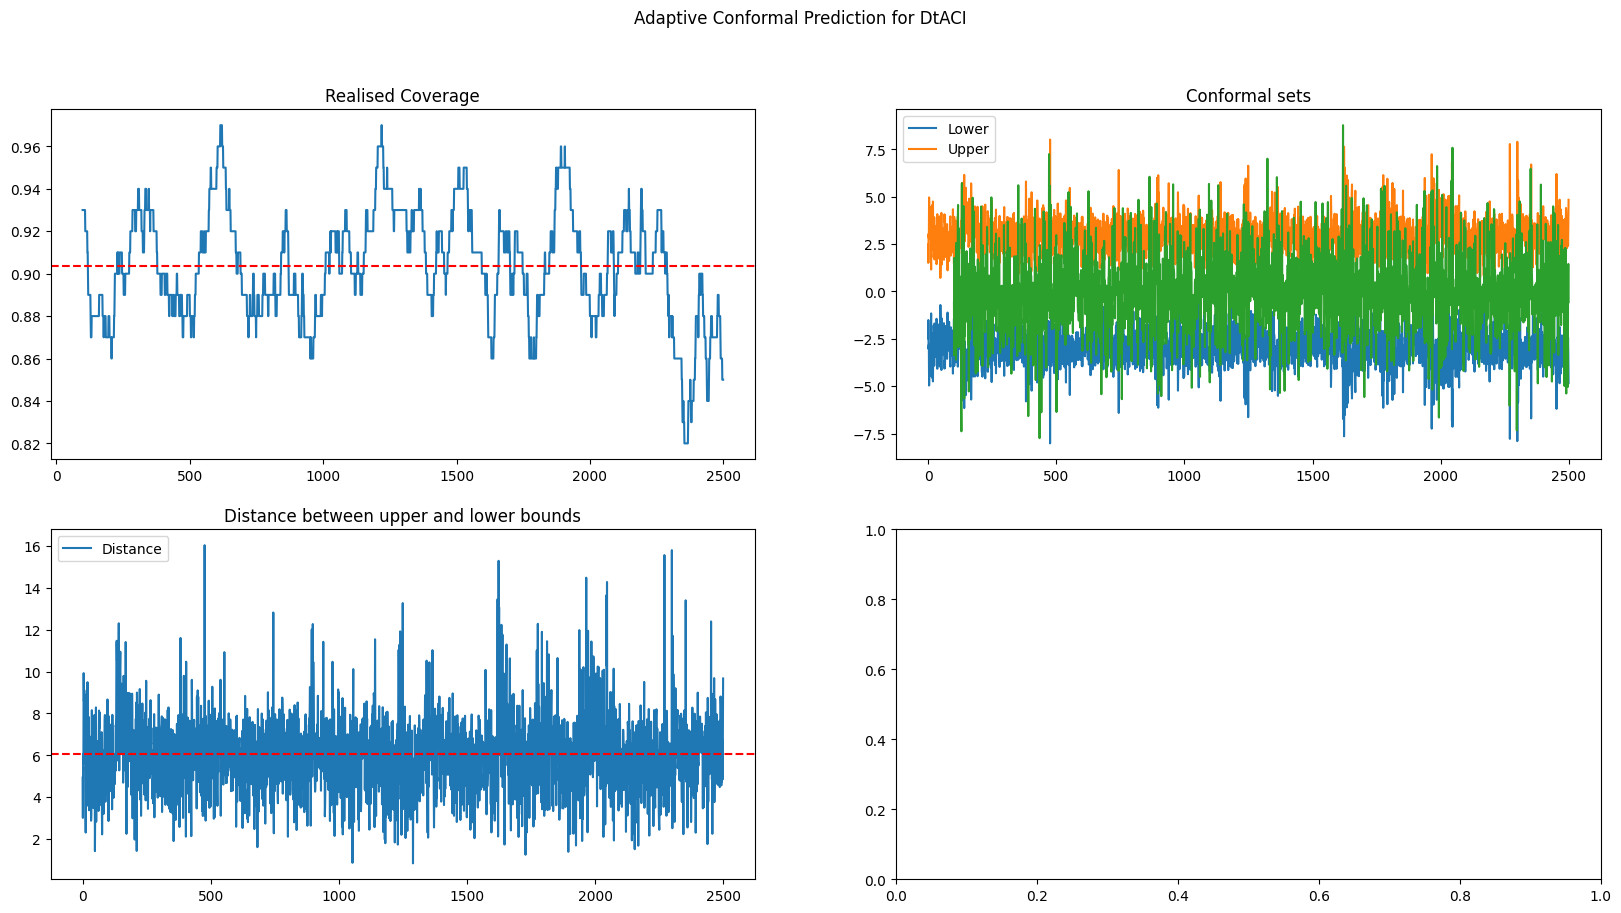

In [13]:
ACP_plots.one_plot(cheb_results, corresponding_normal)

[np.float64(0.8333333333333333), np.float64(0.5), np.float64(0.8333333333333333), np.float64(0.5), np.float64(1.1666666666666665), np.float64(1.2777777777777777), np.float64(1.2777777777777777), np.float64(1.0555555555555556), np.float64(1.1666666666666665), np.float64(0.8333333333333333), np.float64(0.8333333333333333), np.float64(0.5), np.float64(0.7222222222222222), np.float64(1.1666666666666665), np.float64(0.5), np.float64(0.7222222222222222), np.float64(0.8333333333333333), np.float64(0.5), np.float64(0.5), np.float64(0.8333333333333333), np.float64(0.8333333333333333), np.float64(0.8333333333333333), np.float64(0.5), np.float64(0.5), np.float64(0.8333333333333333), np.float64(0.5), np.float64(1.0555555555555556), np.float64(0.6111111111111112), np.float64(0.7222222222222222), np.float64(0.6111111111111112), np.float64(0.5), np.float64(0.6111111111111112), np.float64(0.5), np.float64(0.5), np.float64(0.5), np.float64(0.6111111111111112), np.float64(0.7222222222222222), np.float64

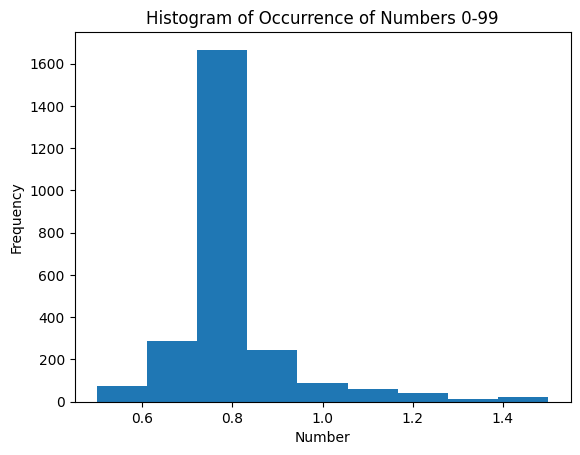

In [14]:
# Extract the chosen_fraction_list from cheb_results
chosen_fraction_list = cheb_results['chosen_fraction_list']
print(chosen_fraction_list)
candidates = cheb_results['fraction_candidates']

# Plot the histogram
plt.hist(chosen_fraction_list, bins=candidates)
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Histogram of Occurrence of Numbers 0-99')
plt.show()

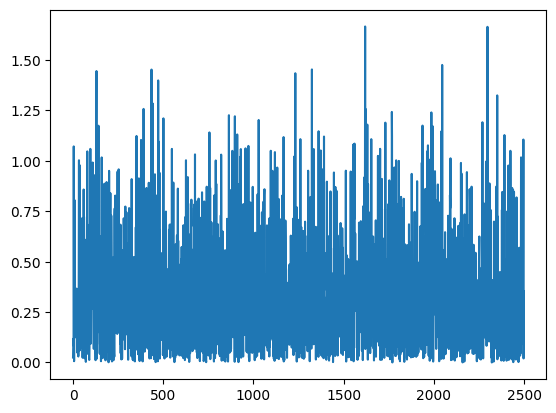

In [15]:
plt.plot(cheb_results['optimal_fraction_list'])
plt.show()

# Results
This method has learnt to properly learnt the discount rate fro cheyshev in normal data. 

The two next things to determine are:
- If it can deal with time series data.
- If it can deal with non perfect variances

Before you do this you should write helper functions to allow for experimentaion to be easier. You should make:

- Creating data. Then you can add functionality to it.
- Plotting the histograms.

You will need to make the following addaptions to the code:

- Make cheb predict sets around the last true value so that it can deal with time series.

In [16]:
# Making the changes to cheb.

class FrCheb(AdaptiveCP):
    def __init__(self, alpha):
        self.alpha = alpha
        self.coverage_target = alpha
        self.interval_size = 100

    def FrCheb_set(self, last, var, alpha, fraction):
        k = np.sqrt(var/alpha)
        return k, (-k*fraction + last, last + k*fraction)
    
    def set_loss(self, optimal_set, given_set):
        # If the optimal set is somehow 0, then we will return the given set.
        if optimal_set == 0:
            return 0
        else:
            val = (optimal_set - given_set)
         
        if val < 0:
            return (self.coverage_target) * (-1* val)
        else:
            return (1 - self.coverage_target) * val

    def FrCheb(self, variance_normal: tuple, min_max_many: tuple = (-0.5, 0.5, 10), title: str = None, verbose=False ) -> dict:
            ''' Implementaion of FrCheb.'''  
            variance_array, normal_array = variance_normal 
            
            fraction_candidates = np.linspace(min_max_many[0], min_max_many[1], min_max_many[2])
        
            final_weights = np.array([1 for _ in fraction_candidates])
            
            chosen_fraction_index = []
            err_t_list = []
            conformal_sets_list = []
            chosen_fraction_list = []
            alpha_error_list = []
            optimal_fraction_list = []
            
            sigma = 1/(2*self.interval_size)
            nu = np.sqrt((3/self.interval_size) * (np.log(len(fraction_candidates)*self.interval_size) + 2)/((1-self.coverage_target)**2 * self.coverage_target**2))

            #set_loss = self.set_loss_vectorize()

            for i in range(1, len(normal_array)):
                if verbose:
                    print(f'{i=}')
                    
                chosen_fraction = random.choices(fraction_candidates, weights=final_weights, k=1)[0] # candidate alpha is redundant, just replace with head values.
                
                chosen_fraction_list.append(chosen_fraction)
                candiate_fraction_index = np.where(fraction_candidates == chosen_fraction)[0][0]
                chosen_fraction_index.append(candiate_fraction_index)

                # This is the generation of the intervals. It does not need to be vectorised.
                cheb_k, conformal_set = self.FrCheb_set(normal_array[i-1], variance_array[i], self.alpha, chosen_fraction)
                conformal_sets_list.append(conformal_set)
                
                err_true = AdaptiveCP.err_t(normal_array[i], conformal_set) 
                err_t_list.append(err_true)

                # TIME FRONTIER -------

                optimal_fraction = abs(normal_array[i])/cheb_k 
                optimal_fraction_list.append(optimal_fraction)
           
                
                set_loss = np.array([self.set_loss(optimal_fraction, fraction) for fraction in fraction_candidates])
                new_weights = final_weights * np.exp(-nu * set_loss) 
                

                sumW, lenW = sum(new_weights), len(new_weights)
                final_weights = new_weights*(1-sigma) + sumW*(sigma/lenW)

                final_weights /= sum(final_weights)

                if verbose:
                    print(f'{optimal_fraction=}')
                    print(f'{set_loss=}')
                    print(f'{final_weights=}')

                
            # Calculating different averages
            realised_interval_coverage = 1 - pd.Series(err_t_list).rolling(self.interval_size).mean().mean()
            average_prediction_interval = np.mean([abs(x[1] - x[0]) for x in conformal_sets_list])
            
            return {
                'model': title if title is not None else 'DtACI',
                'coverage_target': self.coverage_target,
                'fraction_candidates': fraction_candidates,
                'realised_interval_coverage': realised_interval_coverage,
                'average_prediction_interval': average_prediction_interval,
                'chosen_fraction_list': chosen_fraction_list,
                'conformal_sets': conformal_sets_list,
                'error_t_list': err_t_list,
                'alpha_error_list': alpha_error_list,
                'optimal_fraction_list': optimal_fraction_list,
                'interval_size': self.interval_size

            }


In [17]:
# Creating the method for creating the data.

def create_nomrmal_cheb_data(length: int, model_error: float = 0.1, time_series_function: callable = lambda x: x, var_range: tuple = (0.5, 2)) -> tuple:
    '''Model error roughly corresponds to percentage uncertainty in the model.'''
    
    minv, maxv = var_range

    true_variance_array = np.random.uniform(minv, maxv, length)
    corresponding_normal = np.random.normal(0, true_variance_array, length)

    model_variance_array = true_variance_array + np.random.uniform(model_error*minv, model_error*maxv, length)
    time_series_normal = time_series_function(corresponding_normal)

    return model_variance_array, time_series_normal


In [32]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

def plot_histogram(cheb_results):
    chosen_fraction_list = cheb_results['chosen_fraction_list']
    candidates = cheb_results['fraction_candidates']

    plt.hist(chosen_fraction_list, bins=candidates)
    plt.xlabel('Number')
    plt.ylabel('Frequency')
    plt.title('Histogram of Occurrence of Numbers')
    plt.show()

def plot_histogram_segments(cheb_results, num_segments):
    chosen_fraction_list = cheb_results['chosen_fraction_list']
    candidates = cheb_results['fraction_candidates']
    
    segment_size = len(chosen_fraction_list) // num_segments
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(num_segments):
        start = i * segment_size
        end = (i + 1) * segment_size
        
        segment_chosen_fraction_list = chosen_fraction_list[start:end]
        segment_candidates = candidates[start:end]
        
        hist, bins = np.histogram(segment_chosen_fraction_list, bins=segment_candidates)
        xpos, ypos = np.meshgrid(bins[:-1], range(2))
        xpos = xpos.flatten('F')
        ypos = ypos.flatten('F')
        zpos = np.zeros_like(xpos)
        dx = dy = 0.1 * np.ones_like(zpos)
        dz = hist.flatten()
        
        ax.bar3d(xpos, ypos, zpos, dx, dy, dz)
    
    ax.set_xlabel('Number')
    ax.set_ylabel('Segment')
    ax.set_zlabel('Frequency')
    ax.set_title('Histogram of Occurrence of Numbers in Segments')
    
    plt.show()

def plot_histogram_segments(cheb_results, num_segments):
    chosen_fraction_list = cheb_results['chosen_fraction_list']
    candidates = cheb_results['fraction_candidates']
    
    segment_size = len(chosen_fraction_list) // num_segments
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Determine the bins globally, so they are consistent across all segments
    global_bins = np.histogram_bin_edges(chosen_fraction_list, bins='auto')
    
    for i in range(num_segments):
        start = i * segment_size
        end = (i + 1) * segment_size
        
        segment_chosen_fraction_list = chosen_fraction_list[start:end]
        
        # Calculate the histogram for this segment using global_bins
        hist, bins = np.histogram(segment_chosen_fraction_list, bins=global_bins)
        
        # Calculate bar positions and sizes
        xpos = (bins[:-1] + bins[1:]) / 2  # x-coordinates at the center of bins
        ypos = np.full_like(xpos, i)       # y-coordinate is the segment index
        zpos = np.zeros_like(xpos)         # z starts at 0
        dx = (bins[1:] - bins[:-1])        # width of each bin
        dy = np.ones_like(xpos)            # depth is uniform
        dz = hist                          # height is the histogram count
        
        # Plot the bars
        ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Segment')
    ax.set_zlabel('Frequency')
    ax.set_title('Histogram of Occurrence of Numbers in Segments')
    
    plt.show()

In [33]:
data_transformation = lambda x: np.append(x[0], 0.5*x[:-1] + x[1:])
result = create_nomrmal_cheb_data(2500, 0.5, time_series_function=data_transformation)

#plot the data.
plt.plot(result[1])
plt.show()

<IPython.core.display.Javascript object>

In [34]:
frc = FrCheb(0.1)
frc_results = frc.FrCheb(result, min_max_many=(0, 2, 50), verbose=0)

ACP_plots.one_plot(frc_results, result[1])



<IPython.core.display.Javascript object>

In [38]:
tup = (result[1][:-1], result[1][1:])
ACP = AdaptiveCP(0.1)
classic = ACP.ACI(tup, 0.005)

ValueError: operands could not be broadcast together with shapes (2499,) (2448,) 

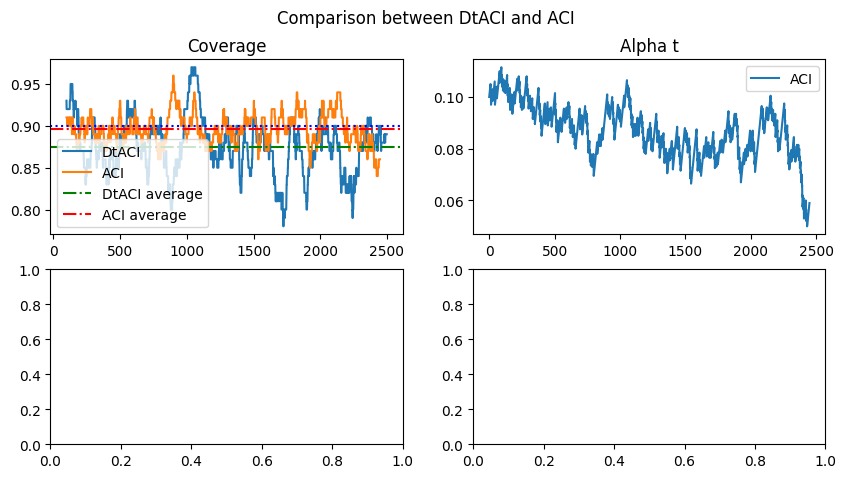

In [46]:
ACP_plots.compare_two(frc_results, classic)

In [36]:
plot_histogram_segments(frc_results, 20)

<IPython.core.display.Javascript object>

Seem to be consitently 0.05 below it. This could potentialy be to do with scaling. 
- Have created the histogram function, you should definetly use with maci as it would be useful to see how it changes.
- Realised that your ability to visualise data is very important.

From here I should look. 
- How it deals with pronounced shifts. See if it performs better then aci.
- Then send to henry and see what he 

In [56]:
data = ACP_data.no_shift((0,1), 2500)
a = data[0][0]
print(a)
print(a[-2:1])
b = [np.var(a[max(0, i-200):i+1]) for i in range(len(a))]
print(b)

[ 0.21502359 -0.76871182  0.82438478 ...  1.25155012  0.8590177
 -0.38498069]
[]
[np.float64(0.0), np.float64(0.24193383740255264), np.float64(0.43077924163987474), np.float64(0.3370824458322782), np.float64(0.2945845386135711), np.float64(0.5125948561087897), np.float64(0.5667928872964517), np.float64(1.047463195650316), np.float64(1.0242345982573824), np.float64(1.1304593053485146), np.float64(1.2866374573706296), np.float64(1.1849239533593496), np.float64(1.1533313344196712), np.float64(1.1018417393403808), np.float64(1.1144928924428437), np.float64(1.054144912900655), np.float64(1.0732779241938282), np.float64(1.0280245171882698), np.float64(1.0409723263180417), np.float64(0.9890748784637371), np.float64(0.9463778510666104), np.float64(0.904672669231556), np.float64(0.8763081801078536), np.float64(0.8967881691139937), np.float64(0.9067295664589982), np.float64(0.8761858214781751), np.float64(0.9300606054966073), np.float64(1.016567306008601), np.float64(0.9887771080430945), np.floa

In [106]:
# Sample variance method.

def turn_into_var(data):
    x = data[0]
    var = [np.var(x[max(0, i-100):i+1]) for i in range(len(x))]
    return (var, data[1])

In [123]:
stock = ACP_data.stock_data(100)

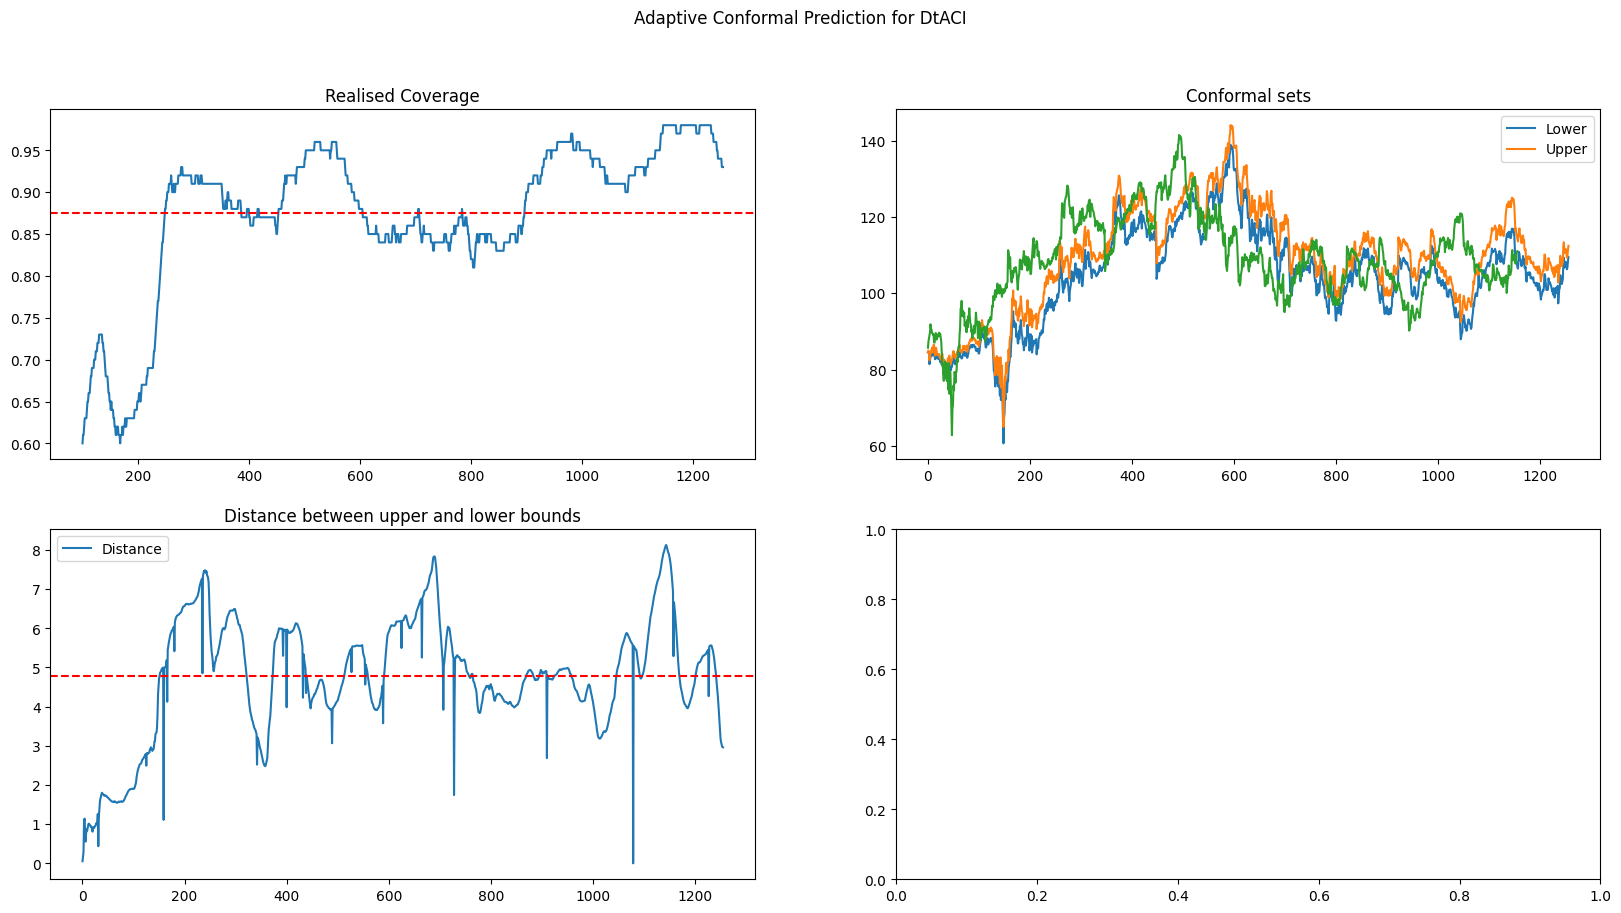

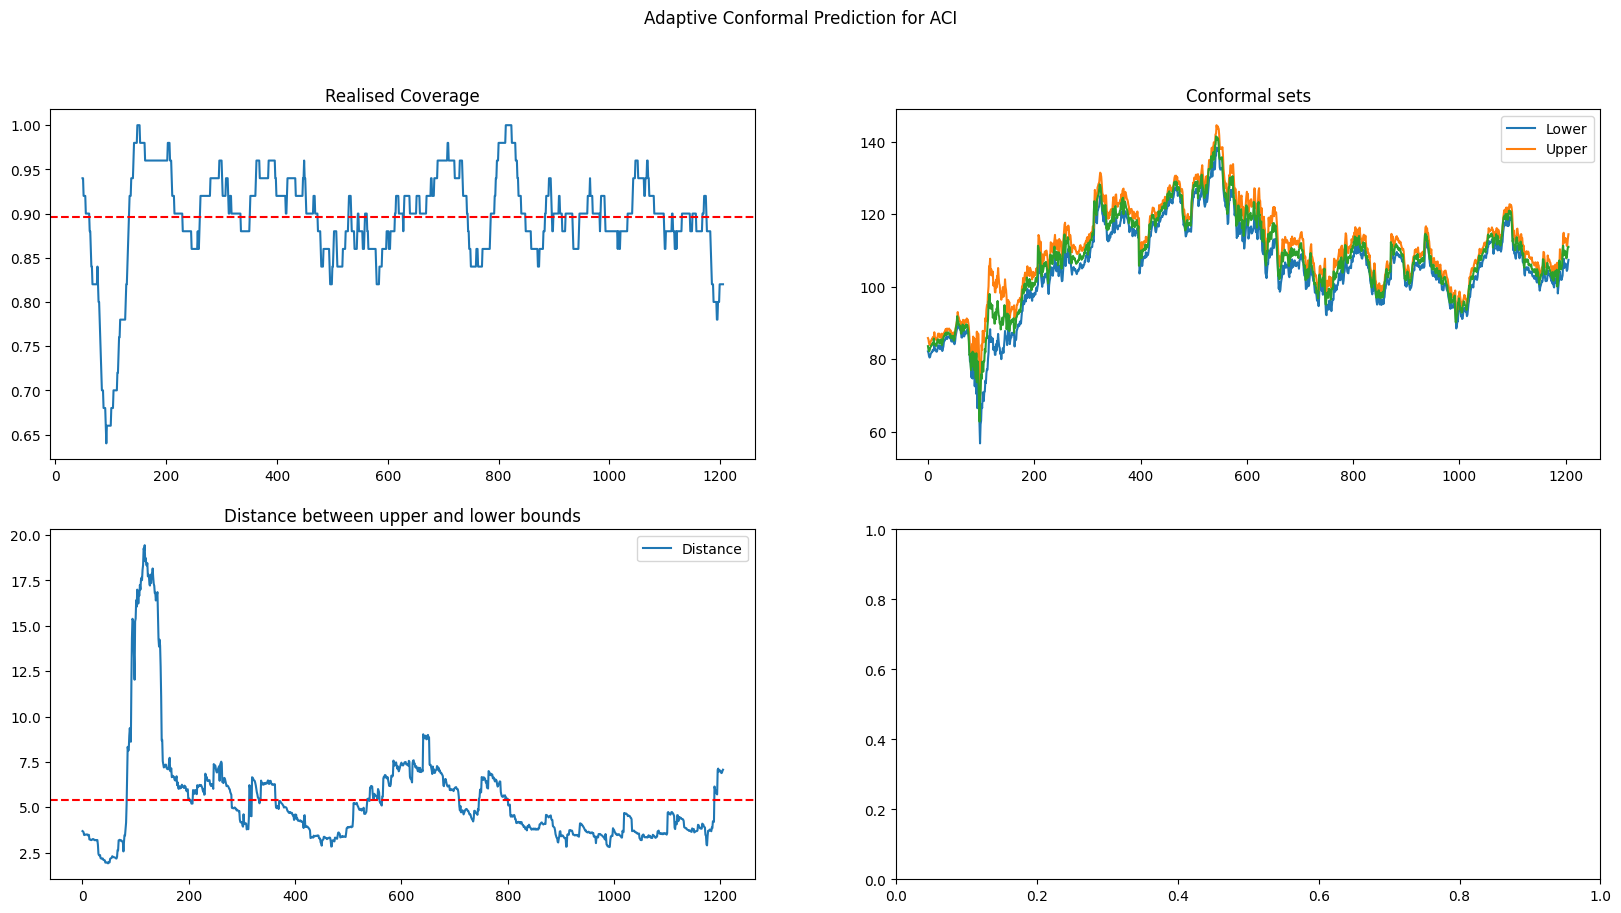

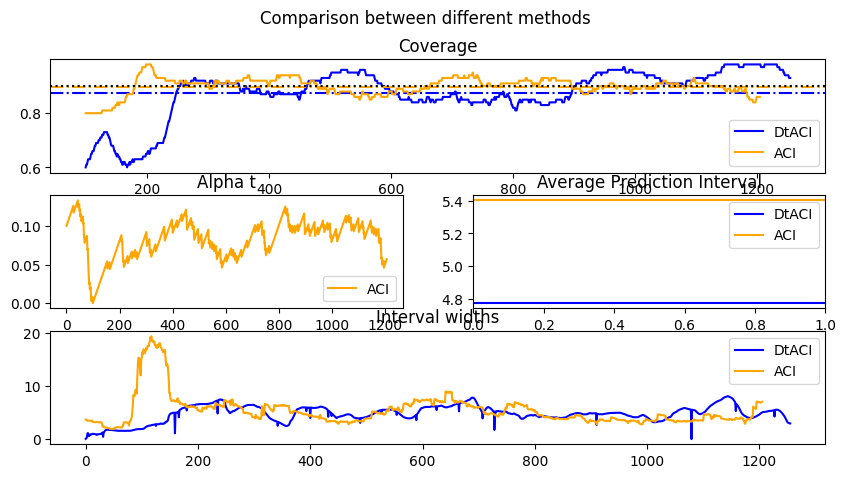

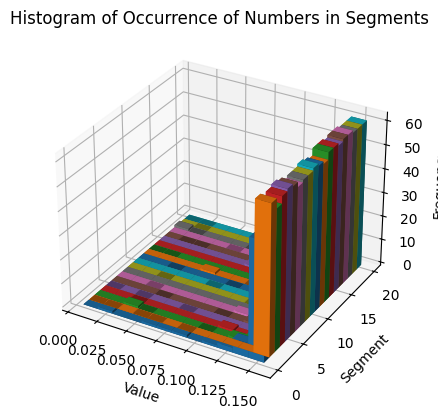

In [140]:
rm = ACP_data.random_multi_shift(1, (2500,2501))[0]
rm = stock[5]
var_rm = turn_into_var(rm)

aci = ACP.ACI(rm, 0.01)
chebed = frc.FrCheb(var_rm, min_max_many=(0, 0.15, 10), verbose=0)
ACP_plots.one_plot(chebed, var_rm[1])
ACP_plots.one_plot(aci, var_rm[1])
ACP_plots.compare_many([chebed, aci])
plot_histogram_segments(chebed, 20)


This illustrates that it has no momentum to decrease weight. Although the heads with the smaller weights should be getting penalised less however this is clealy not what is happening. Why could this make sense.
- It is clear that the value which should perform the best shoudl be around 0.15 however this doesn not seem to gain any momentum it always favours the larger head.

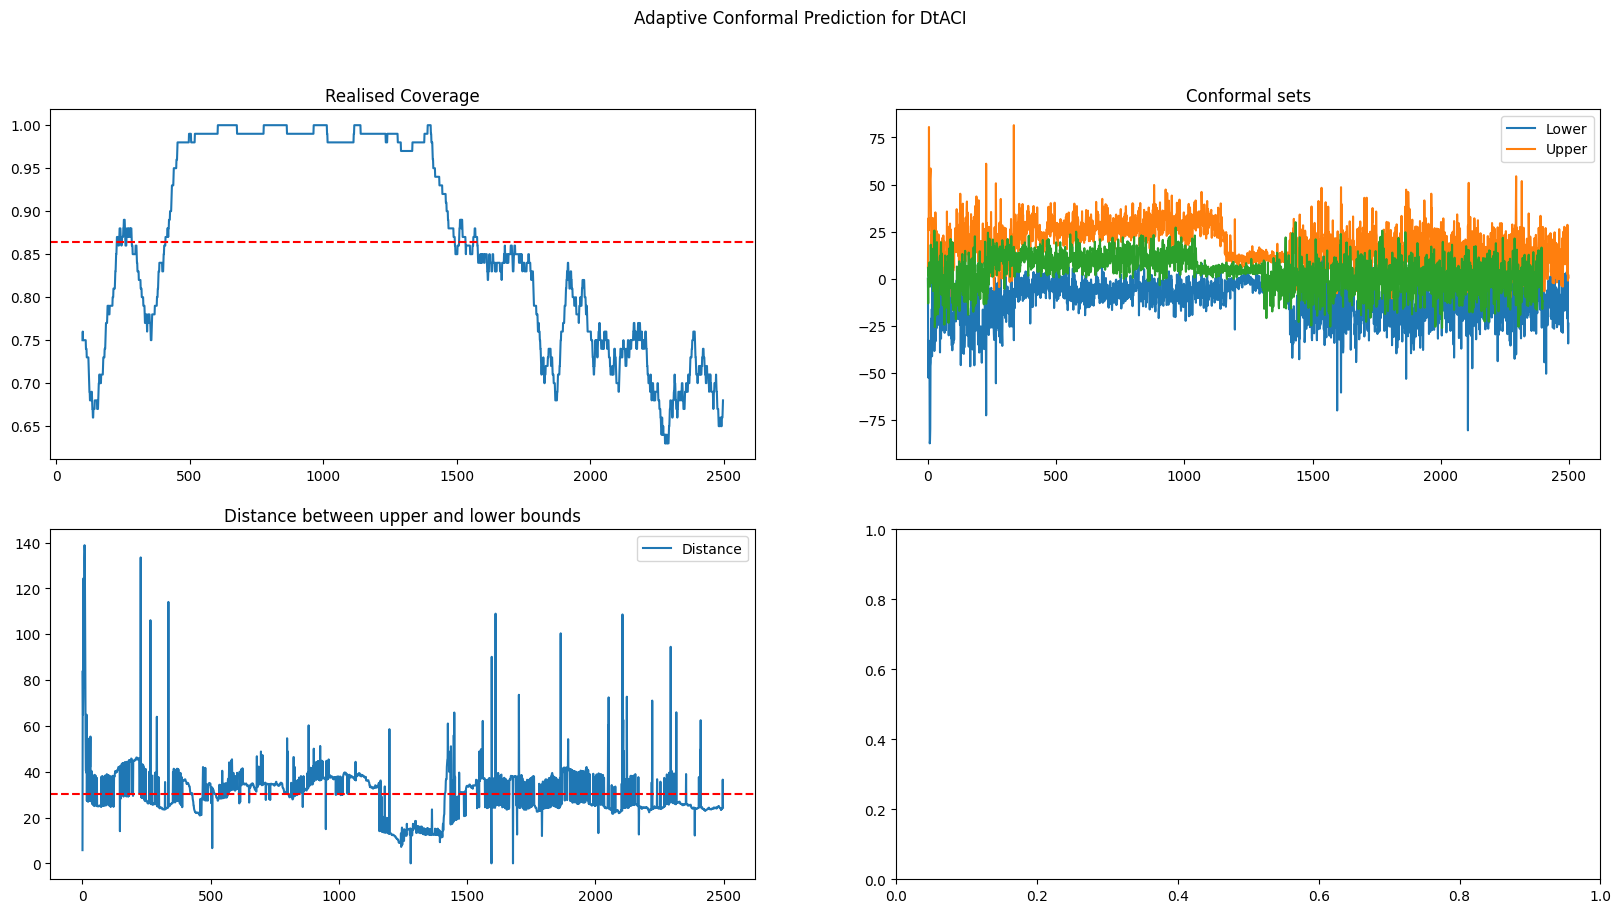

In [108]:
ACP_plots.one_plot(chebed, var_rm[1])